In [1]:
import os
from pathlib import Path
import cv2
import numpy as np
from ultralytics import YOLO


def prepare_dataset(dataset_path):
    images_dir = Path(dataset_path) / 'images'
    annotations_dir = Path(dataset_path) / 'annotations'
    
    # Create lists to store paths
    image_paths = []
    annotation_paths = []
    
    # Get all image and annotation files
    for img_file in images_dir.glob('*.png'):
        # Get corresponding annotation file
        ann_file = annotations_dir / (img_file.stem + '.xml')
        if ann_file.exists():
            image_paths.append(str(img_file))
            annotation_paths.append(str(ann_file))
    
    print(f"Found {len(image_paths)} images with annotations")
    return image_paths, annotation_paths

# Load the dataset
dataset_path = "/Users/dinukkarunaratne/Desktop/EOG/dataset"  # Update this path
image_paths, annotation_paths = prepare_dataset(dataset_path)

# Test loading an image
def test_image_load(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(f"Image shape: {img.shape}")
    return img

# Test with first image
if image_paths:
    test_img = test_image_load(image_paths[0])

Found 433 images with annotations
Image shape: (478, 400, 3)


In [2]:
from ultralytics import YOLO
import cv2
from PIL import Image

# Load a pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')  # or use a specific license plate model

def detect_license_plate(image_path):
    # Run inference
    results = model(image_path)
    
    # Process results (first image, first detection)
    if len(results) > 0:
        boxes = results[0].boxes
        if len(boxes) > 0:
            # Get coordinates of first detected plate
            box = boxes[0]
            coords = box.xyxy[0].tolist()  # get coordinates
            confidence = box.conf[0].item()  # get confidence score
            return coords, confidence
    return None, 0.0

In [3]:
import xml.etree.ElementTree as ET

def convert_xml_to_yolo(xml_path, image_width, image_height):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # For license plates, we only have one class (0)
    class_id = 0
    
    yolo_annotations = []
    
    for obj in root.findall('./object'):
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        
        # Convert to YOLO format (normalized center x, center y, width, height)
        x_center = ((xmin + xmax) / 2) / image_width
        y_center = ((ymin + ymax) / 2) / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height
        
        yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")
    
    return yolo_annotations

# Test conversion with first image/annotation pair
if image_paths and annotation_paths:
    img = cv2.imread(image_paths[0])
    height, width = img.shape[:2]
    yolo_anns = convert_xml_to_yolo(annotation_paths[0], width, height)
    print("YOLO format annotations:", yolo_anns)

YOLO format annotations: ['0 0.7825 0.5156903765690377 0.295 0.07322175732217573']


In [4]:
# Load pre-trained model without fine-tuning
model = YOLO('yolov8n.pt')

# Test on one of your images
test_image = image_paths[27]
results = model(test_image)

# Print what was detected
print("Detected classes:", [results[0].names[int(cls)] for cls in results[0].boxes.cls])
print("Confidence scores:", results[0].boxes.conf.tolist())


image 1/1 /Users/dinukkarunaratne/Desktop/EOG/dataset/images/Cars52.png: 480x640 1 car, 2 trucks, 128.5ms
Speed: 3.3ms preprocess, 128.5ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 640)
Detected classes: ['car', 'truck', 'truck']
Confidence scores: [0.670912504196167, 0.4476380944252014, 0.26349273324012756]


In [5]:
# Load pre-trained model
model = YOLO('yolov8n.pt')

# Test on all images
total_images = len(image_paths)
detections = []

print("Testing pre-trained model on all images...")
for idx, img_path in enumerate(image_paths):
    results = model(img_path)
    
    # Get detections for this image
    classes = [results[0].names[int(cls)] for cls in results[0].boxes.cls]
    scores = results[0].boxes.conf.tolist()
    
    detections.append({
        'image': Path(img_path).name,
        'detected_classes': classes,
        'confidence_scores': scores
    })
    
    # Print progress every 50 images
    if (idx + 1) % 50 == 0:
        print(f"Processed {idx + 1}/{total_images} images")

# Analyze results
images_with_detections = sum(1 for d in detections if d['detected_classes'])
most_common_classes = {}

for d in detections:
    for cls in d['detected_classes']:
        most_common_classes[cls] = most_common_classes.get(cls, 0) + 1

print("\nSummary:")
print(f"Total images: {total_images}")
print(f"Images with any detection: {images_with_detections}")
print(f"Images with no detections: {total_images - images_with_detections}")
if most_common_classes:
    print("\nMost commonly detected classes:")
    for cls, count in sorted(most_common_classes.items(), key=lambda x: x[1], reverse=True):
        print(f"{cls}: {count} detections")

Testing pre-trained model on all images...

image 1/1 /Users/dinukkarunaratne/Desktop/EOG/dataset/images/Cars207.png: 640x544 (no detections), 67.2ms
Speed: 1.8ms preprocess, 67.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /Users/dinukkarunaratne/Desktop/EOG/dataset/images/Cars213.png: 480x640 1 person, 1 car, 1 truck, 90.9ms
Speed: 1.4ms preprocess, 90.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /Users/dinukkarunaratne/Desktop/EOG/dataset/images/Cars53.png: 480x640 1 car, 71.0ms
Speed: 1.9ms preprocess, 71.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /Users/dinukkarunaratne/Desktop/EOG/dataset/images/Cars47.png: 480x640 2 cars, 1 chair, 44.4ms
Speed: 1.4ms preprocess, 44.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /Users/dinukkarunaratne/Desktop/EOG/dataset/images/Cars90.png: 480x640 4 persons, 7 cars, 45.1ms
Speed: 1.2ms preprocess, 45.1ms infe


image 1/1 /Users/dinukkarunaratne/Desktop/EOG/dataset/images/Cars52.png: 480x640 1 car, 2 trucks, 55.4ms
Speed: 1.3ms preprocess, 55.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


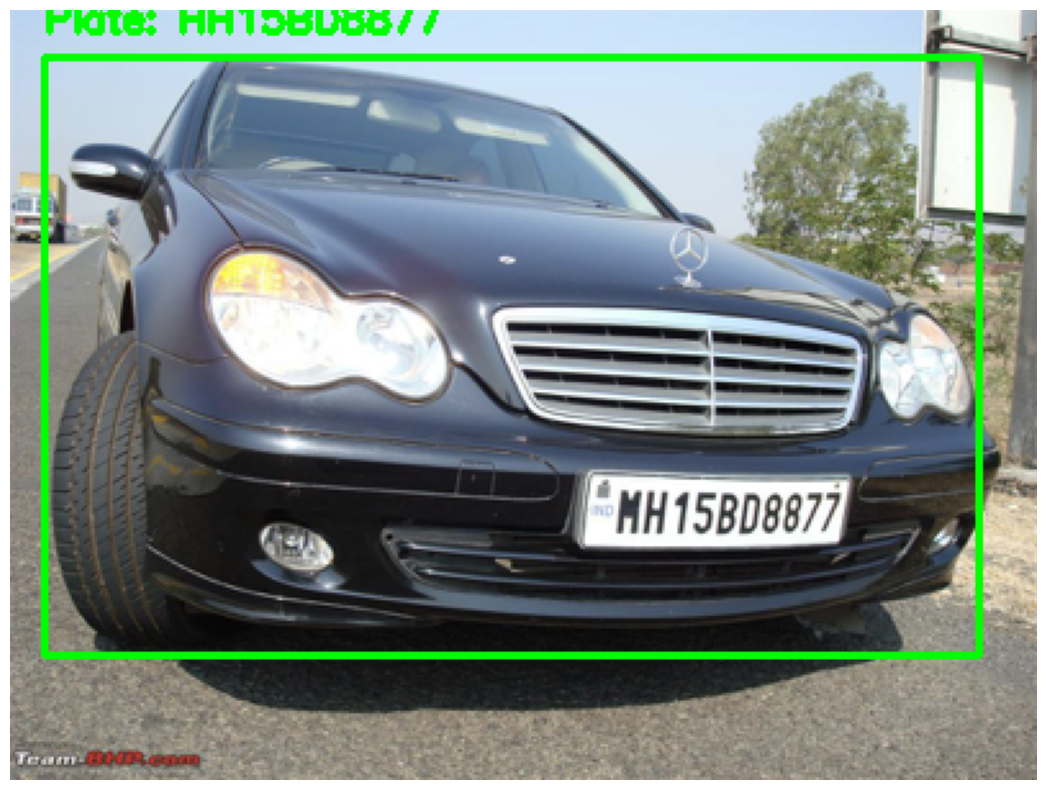


Detected plates: [{'text': 'HH15BD8877', 'confidence': 0.7322994803954308, 'car_bbox': [13, 18, 377, 251]}]
433


In [6]:
from ultralytics import YOLO
import cv2
import easyocr # for reading text
import numpy as np
import matplotlib.pyplot as plt  # Add this import

# Initialize models
yolo_model = YOLO('yolov8n.pt')  # for car detection
reader = easyocr.Reader(['en'])   # for reading license plates

def detect_and_read_plate(image_path):
    # 1. Detect car first
    results = yolo_model(image_path)
    img = cv2.imread(image_path)
    
    plates_text = []
    
    # 2. For each car detected
    for box in results[0].boxes:
        if results[0].names[int(box.cls)] == 'car':
            # Get car coordinates
            x1, y1, x2, y2 = box.xyxy[0].numpy().astype(int)
            
            # Extract car region and adjust contrast
            car_region = img[y1:y2, x1:x2]
            if car_region.size == 0:
                continue
                
            # Enhance image for better plate detection
            gray = cv2.cvtColor(car_region, cv2.COLOR_BGR2GRAY)
            gray = cv2.equalizeHist(gray)
            
            # Use EasyOCR to find text in car region
            texts = reader.readtext(gray)
            
            # Filter for likely license plate text
            for (bbox, text, prob) in texts:
                # Basic filter for license plate format
                if len(text) >= 5 and prob > 0.5:  # adjust these thresholds
                    plates_text.append({
                        'text': text,
                        'confidence': prob,
                        'car_bbox': [x1, y1, x2, y2]
                    })
    
    return plates_text

# Test on an image
def test_detection(image_path):
    plates = detect_and_read_plate(image_path)
    img = cv2.imread(image_path)
    
    # Draw results
    for plate in plates:
        # Draw car box
        x1, y1, x2, y2 = plate['car_bbox']
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Write plate text
        cv2.putText(img, f"Plate: {plate['text']}", 
                    (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 255, 0), 2)
    
    # Display result
    plt.figure(figsize=(15,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    return plates

# First install EasyOCR if you haven't:
# !pip install easyocr

# Test on one image
test_image = image_paths[27]
results = test_detection(test_image)
print("\nDetected plates:", results)
print(len(image_paths))

In [8]:
import random
from datetime import datetime
import pandas as pd
import os
import re

FOOD_ITEMS = [
    "Big Mac", "Quarter Pounder", "Chicken McNuggets", "McChicken",
    "French Fries", "Cheeseburger", "Fish Fillet", "Apple Pie",
    "McFlurry", "Chicken Sandwich", "Salad", "Happy Meal"
]

NAMES = [
    "John Smith", "Emma Wilson", "Michael Brown", "Sarah Davis",
    "James Johnson", "Lisa Anderson", "David Miller", "Jennifer Garcia",
    "Robert Taylor", "Maria Martinez", "William Jones", "Susan Lee"
]

# Initialize customer database
# if os.path.exists("customer_database.csv"):
#     customer_db = pd.read_csv("customer_database.csv")
DB_PATH = "/Users/dinukkarunaratne/Desktop/EOG/app/data/customer_database.csv"
if os.path.exists(DB_PATH):
    customer_db = pd.read_csv(DB_PATH)
else:
    customer_db = pd.DataFrame(columns=['license_plate', 'name', 'last_order', 'last_visit', 'total_visits', 'preferred_time'])

def get_all_plates_from_dataset(image_paths):
    """Get plates from all images and track images with no detections"""
    all_plates = []
    no_plate_images = []
    
    print("Processing all images...")
    for idx, img_path in enumerate(image_paths):
        plates = detect_and_read_plate(img_path)
        
        if plates:  # If plates were detected
            for plate in plates:
                plate_number = plate['text']
                confidence = plate['confidence']
                plate_number = re.sub(r'[^A-Z0-9]', '', plate_number.upper())
                # Add detected plate to the database
                add_customer_manually(plate_number)
                
                all_plates.append({
                    'plate_number': plate_number,
                    'confidence': confidence,
                    'image_path': img_path
                })
        else:  # No plates detected
            no_plate_images.append(img_path)
            
        if (idx + 1) % 10 == 0:  # Progress update
            print(f"Processed {idx + 1}/{len(image_paths)} images")
    
    return all_plates, no_plate_images

def add_customer_manually(plate_number):
    """Manually add a customer with automatic details and save to CSV"""
    global customer_db

    if plate_number in customer_db['license_plate'].values:
        return  

    new_customer = {
        'license_plate': plate_number,
        'name': random.choice(NAMES),
        'last_order': random.sample(FOOD_ITEMS, random.randint(1, 4)),
        'last_visit': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'total_visits': random.randint(1, 20),
        'preferred_time': f"{random.randint(10, 21)}:00"
    }
    
    customer_db = pd.concat([customer_db, pd.DataFrame([new_customer])], ignore_index=True)
    customer_db.to_csv('/Users/dinukkarunaratne/Desktop/EOG/app/data/customer_database.csv', index=False)


# Example image paths (Replace with actual image paths)


# Process all images
detected_plates, failed_images = get_all_plates_from_dataset(image_paths)

# Print summary
print("\nSummary:")
print(f"Total images processed: {len(image_paths)}")
print(f"Total plates detected: {len(detected_plates)}")
print(f"Images with no plates detected: {len(failed_images)}")

# Save final database
customer_db.to_csv('customer_database.csv', index=False)
print("\nDatabase saved to customer_database.csv")

# # Print paths of images with no detections
# print("\nImages with no plate detections:")
# for img_path in failed_images:
#     print(f"- {Path(img_path).name}")

# # Example of manually adding a plate
# print("\nExample of manually adding a plate:")
#add_customer_manually("ABC123")



Processing all images...

image 1/1 /Users/dinukkarunaratne/Desktop/EOG/dataset/images/Cars207.png: 640x544 (no detections), 68.9ms
Speed: 4.5ms preprocess, 68.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /Users/dinukkarunaratne/Desktop/EOG/dataset/images/Cars213.png: 480x640 1 person, 1 car, 1 truck, 52.6ms
Speed: 1.2ms preprocess, 52.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /Users/dinukkarunaratne/Desktop/EOG/dataset/images/Cars53.png: 480x640 1 car, 84.1ms
Speed: 2.9ms preprocess, 84.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /Users/dinukkarunaratne/Desktop/EOG/dataset/images/Cars47.png: 480x640 2 cars, 1 chair, 76.6ms
Speed: 1.5ms preprocess, 76.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /Users/dinukkarunaratne/Desktop/EOG/dataset/images/Cars90.png: 480x640 4 persons, 7 cars, 104.2ms
Speed: 1.8ms preprocess, 104.2ms inference, 0.6ms pos